/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


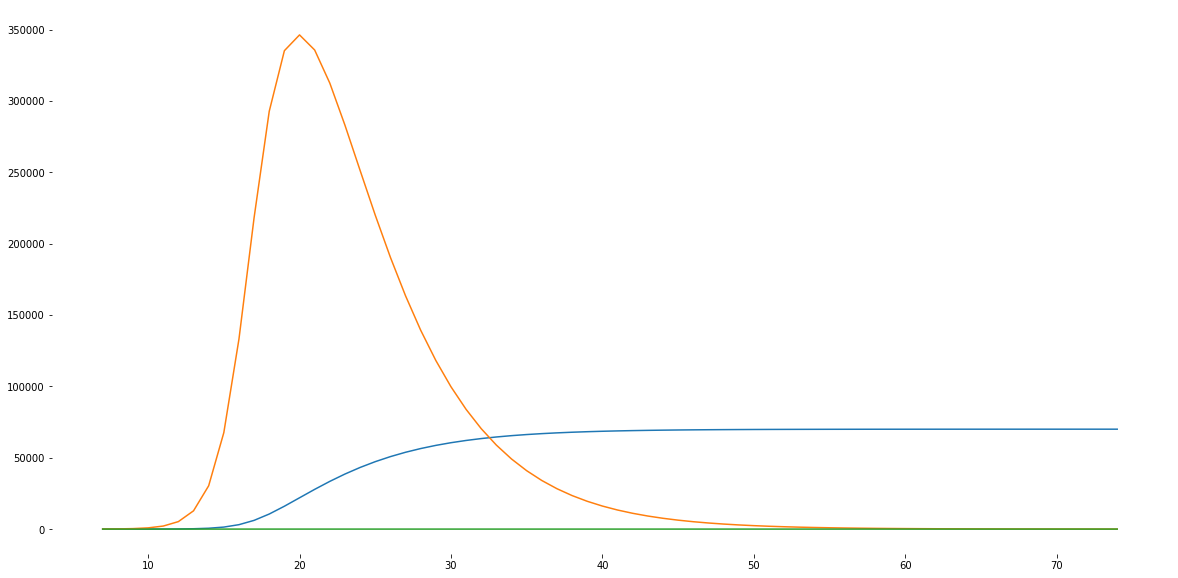

In [64]:
from scipy.integrate import odeint
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sin
import pandas as pd

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

# This is so that we can call "json.dumps" on Numpy arrays
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# User defined constants
N = 735334.0
Tinc = 5.2
Tinf = 2.9
pHosp = 0.2
Rt = 2.2

# The ODE system
def deriv_(y_, t_):
    E, I, H, R, S = y_
    dE_ = (Rt / Tinf * (I + H) * S / N - E / Tinc) * 1.0
    dI_ = (E / Tinc * (1.0 - pHosp) - I / Tinf) * 1.0
    dH_ = (E / Tinc * pHosp - H / Tinf) * 1.0
    dR_ = (I + H) / Tinf * 1.0
    dS_ = -(Rt / Tinf) * (I + H) * S / N * 1.0
    return dE_, dI_, dH_, dR_, dS_

# Boundary conditions and setup
timeRange_ = np.arange(0.0, 75.0, 1.0)
y0_ = 0.0, 1.0, 0.0, 0.0, 7000000.0
output = odeint(deriv_, y0_, timeRange_)

df = pd.DataFrame(output)
df = df.reset_index()
df.columns = ['Day', 'Exposed', 'Mild', 'Critical', 'Recovered', 'Susceptible']
df['Dead'] = df['Recovered'].apply(lambda x: x * 0.01)
df['Infected'] = df['Mild'] + df['Critical']
x = list(df['Day'])
y = list(df['Dead'])
y2 = list(df['Critical'])

firstDeath = next(x for x, val in enumerate(y) if val >= 1.0)
x = x[firstDeath:]
y = y[firstDeath:]
y2 = y2[firstDeath:]

covidDeath = pd.read_csv('covid_deaths_usafacts.csv')
multnomah = covidDeath[covidDeath['State'].str.contains('OR')][covidDeath['County Name'].str.contains('Multn')]
d = list(multnomah.iloc[0])[4:]
firstDeath = next(x for x, val in enumerate(d) if val >= 1.0)
d = d[firstDeath:]
d = d + [0]*(len(x) - len(d))


plt.figure(figsize=(20, 10))  

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
#ax.set_xlim(x[0], x[20])

plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x, d)
